use same interactive selection to interactively draw and label areas in an image
same as before, depending on class, append to list with class as first column
save this as a dataframe
if big, take random fraction maybe 30-50%, then to csv

when running validation: run on the remainder of the data and check if output matches the class from csv/df

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize 
import skimage
from scipy.ndimage import zoom
import pandas as pd
import PyQt5
import glob
%matplotlib inline

In [2]:
#filepaths
folder_fp = 'validation1-20220215/'
fp_hyper = glob.glob(folder_fp + 'hyper/*.bin')[0]

fp_swir = glob.glob(folder_fp + 'swir/*.bin')[0]
fp_rgb_hyper = glob.glob(folder_fp + 'hyper/*.png')[0]


#print filenmaes so can get the size of array for resizing
print(f'hyper path: {fp_hyper}')
print(f'swir path: {fp_swir}')

#maybe make function to get x size, cause string size is conistent should be pretty easy to ge a substring function

hyper path: validation1-20220215/hyper\reorder_272_4063_640_U16.bin
swir path: validation1-20220215/swir\Reorder_288_4093_384_U16.bin


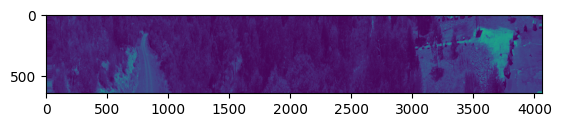

In [4]:
#load images
im_hyper = np.fromfile(fp_hyper,dtype='uint16')
im_hyper = (im_hyper-np.min(im_hyper))/(np.max(im_hyper)-np.min(im_hyper)) #nomralised
im_hyper = im_hyper.reshape([272,4063,640])

im_hyper =  np.transpose(im_hyper,(0,2,1))
plt.imshow(im_hyper[100,:,:])
plt.show()

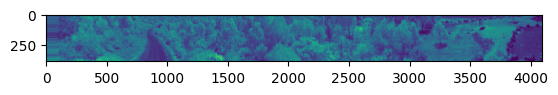

In [5]:
im_swir = np.fromfile(fp_swir,dtype='uint16')
im_swir = (im_swir-np.min(im_swir))/(np.max(im_swir)-np.min(im_swir)) #nomralised
im_swir = im_swir.reshape([288,4093,384])

im_swir =  np.transpose(im_swir,(0,2,1))
im_swir = np.fliplr(im_swir)

plt.imshow(im_swir[100,:,:])
plt.show()

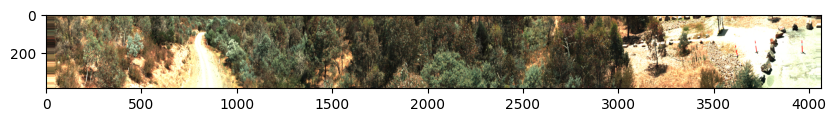

In [6]:
#downscale rgb image to do selection

rgb_swir = skimage.io.imread(fp_rgb_hyper)
rgb_resized = resize(rgb_swir, (rgb_swir.shape[0]*0.6,rgb_swir.shape[1]),anti_aliasing=True)
plt.figure(figsize=(10,10))
plt.imshow(rgb_resized)
plt.show()

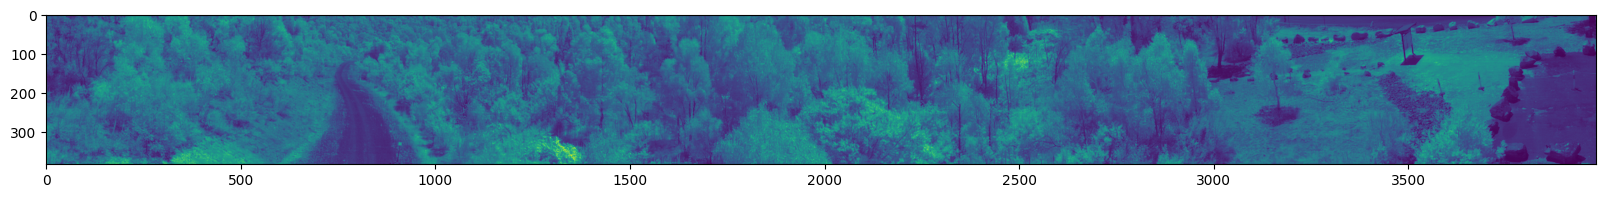

In [7]:
#take smaller crops of the same size from both\

#1 remove noise from sides of swir
plt.figure(figsize=(20,10))
swir = im_swir[:,:,90:im_swir.shape[2]-20]
plt.imshow(swir[100,:,:])

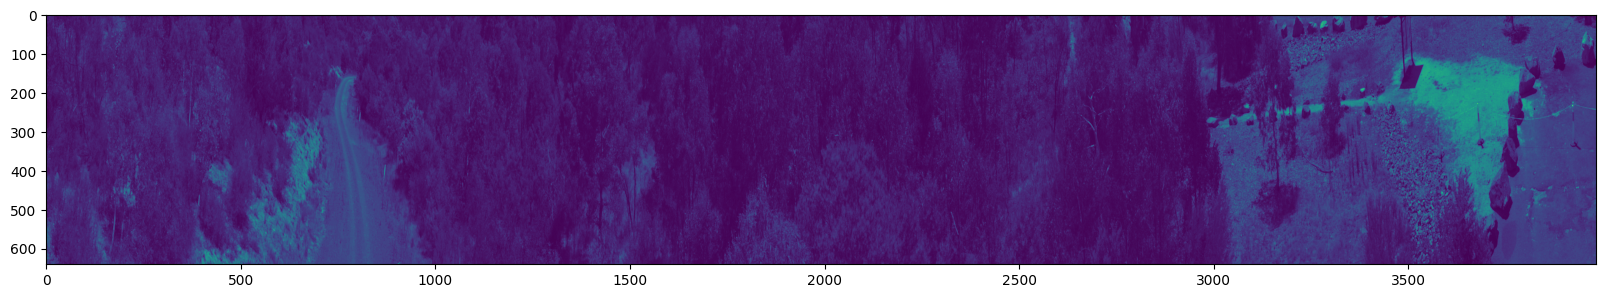

In [8]:
#2 clean up sides of hyper
plt.figure(figsize=(20,10))
hyp = im_hyper[:,:,39:im_hyper.shape[2]-41]
plt.imshow(hyp[100,:,:])

In [9]:
#ensure that htey are the same size, aligned etc
print('swir, hyp shape')
print(swir.shape, hyp.shape)

swir, hyp shape
(288, 384, 3983) (272, 640, 3983)


In [10]:
#make hyper smaller on y axis for fusion (so that it matches the height of swir)
resized = zoom(hyp,(1,0.6,1))

In [11]:
print(swir.shape, resized.shape)

(288, 384, 3983) (272, 384, 3983)


In [12]:
##concatenate the data
SWIR_INDEX = 107 # which wavelength index to slice swir data at
swir_crop = swir[SWIR_INDEX:,:,:]  # take 95th wavelength and onwards, as before this just rubbish n noise
fuse = np.concatenate((resized,swir_crop),axis=0)
fuse.shape

(453, 384, 3983)

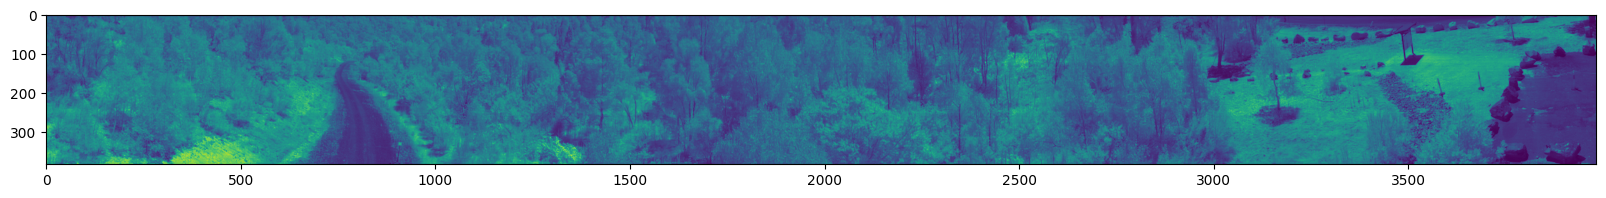

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(fuse[300,:,:])

In [22]:
#initialise lists to hold training ROIs
#run this cell to clear the data or something
tree_trains = []
road_trains = []
dry_trains = []

%matplotlib qt

In [23]:
from matplotlib.widgets import EllipseSelector, RectangleSelector
import matplotlib.pyplot as plt
# https://matplotlib.org/stable/gallery/widgets/rectangle_selector.html


#training data for tree
def select_callback(eclick, erelease):
    """
    Callback for line selection.

    *eclick* and *erelease* are the press and release events.
    """
    x1, y1 = int(eclick.xdata), int(eclick.ydata)
    x2, y2 = int(erelease.xdata), int(erelease.ydata)
    print(f"({x1}, {y1}) --> ({x2}, {y2})")
    # print(f"The buttons you used were: {eclick.button} {erelease.button}")
    roi = fuse[:,min(y1,y2):max(y1,y2),min(x1,x2):max(x1,x2)]
    tree_trains.append(roi)

fig, ax = plt.subplots(1,1,figsize=(20,10))
selectors = []
ax.imshow(rgb_resized)  # plot something
ax.set_title(f"select validation data: click and drag to draw a rectangle (tree)")
selectors.append(RectangleSelector(
    ax, select_callback,
    useblit=True,
    button=[1, 3],  # disable middle button
    minspanx=5, minspany=5,
    spancoords='pixels',
    interactive=True))
# fig.canvas.mpl_connect('key_press_event', keypress)
plt.show()

(2039, 237) --> (2164, 341)
(2821, 107) --> (2938, 196)
(267, 33) --> (330, 90)
(921, 44) --> (989, 107)


In [24]:
from matplotlib.widgets import EllipseSelector, RectangleSelector
import numpy as np
import matplotlib.pyplot as plt
# https://matplotlib.org/stable/gallery/widgets/rectangle_selector.html


#training data for road
def select_callback(eclick, erelease):
    """
    Callback for line selection.

    *eclick* and *erelease* are the press and release events.
    """
    x1, y1 = int(eclick.xdata), int(eclick.ydata)
    x2, y2 = int(erelease.xdata), int(erelease.ydata)
    print(f"({x1}, {y1}) --> ({x2}, {y2})")
    # print(f"The buttons you used were: {eclick.button} {erelease.button}")
    roi = fuse[:,min(y1,y2):max(y1,y2),min(x1,x2):max(x1,x2)]
    road_trains.append(roi)

fig, ax = plt.subplots(1,1,figsize=(20,10))
selectors = []
ax.imshow(rgb_resized)  # plot something
ax.set_title(f"select validation data: click and drag to draw a rectangle (road)")
selectors.append(RectangleSelector(
    ax, select_callback,
    useblit=True,
    button=[1, 3],  # disable middle button
    minspanx=5, minspany=5,
    spancoords='pixels',
    interactive=True))
# fig.canvas.mpl_connect('key_press_event', keypress)
plt.show()

(807, 325) --> (894, 368)
(807, 218) --> (856, 275)
(3902, 286) --> (4025, 363)
(3979, 101) --> (4044, 161)


In [25]:
from matplotlib.widgets import EllipseSelector, RectangleSelector
import numpy as np
import matplotlib.pyplot as plt
# https://matplotlib.org/stable/gallery/widgets/rectangle_selector.html


#training data for dry
def select_callback(eclick, erelease):
    """
    Callback for line selection.

    *eclick* and *erelease* are the press and release events.
    """
    x1, y1 = int(eclick.xdata), int(eclick.ydata)
    x2, y2 = int(erelease.xdata), int(erelease.ydata)
    print(f"({x1}, {y1}) --> ({x2}, {y2})")
    # print(f"The buttons you used were: {eclick.button} {erelease.button}")
    roi = fuse[:,min(y1,y2):max(y1,y2),min(x1,x2):max(x1,x2)]
    dry_trains.append(roi)

fig, ax = plt.subplots(1,1,figsize=(20,10))
selectors = []
ax.imshow(rgb_resized)  # plot something
ax.set_title(f"select validation data: click and drag to draw a rectangle (dry)")
selectors.append(RectangleSelector(
    ax, select_callback,
    useblit=True,
    button=[1, 3],  # disable middle button
    minspanx=5, minspany=5,
    spancoords='pixels',
    interactive=True))
# fig.canvas.mpl_connect('key_press_event', keypress)
plt.show()

(583, 305) --> (641, 360)
(3273, 308) --> (3398, 368)
(3104, 330) --> (3210, 371)
(3085, 221) --> (3123, 251)
(3643, 3) --> (3733, 44)


In [26]:
validation = [] # list to convert into df


def spectra_list(roi,idx):
    '''
    roi - region of interest from the source image
    idx - class of the region for the ML model
    '''
    tmp = []
    for i in range(roi[0,:,:].shape[1]):
        for j in range(roi[0,:,:].shape[0]):
            spectra = roi[:,j,i]
            tmp.append([idx,*spectra])
    roi_list = np.array(tmp)
    return roi_list


In [27]:
#add all the validation data to a list so it can be converted easily into a dataframe then csv
for region in tree_trains:
    lst = spectra_list(region,1)
    validation.append(lst)

for region in road_trains:
    lst = spectra_list(region,2)
    validation.append(lst)

for region in dry_trains:
    lst = spectra_list(region,3)
    validation.append(lst)

In [28]:
#create the dataframe 
validation_df = pd.DataFrame(np.concatenate(validation), columns=[['class']+list(np.arange(0,fuse.shape[0]))])
validation_df.tail(5)

,class,0,1,2,3,4,5,6,7,8,...,443,444,445,446,447,448,449,450,451,452
64160,3.0,-8.472729e-09,0.025725,0.037674,0.043668,0.045463,0.052004,0.052615,0.060876,0.058262,...,0.001422,0.002911,0.002867,0.003644,0.004222,0.004400,0.003422,0.001756,0.001822,0.001622
64161,3.0,2.464941e-07,0.028280,0.033846,0.041447,0.043924,0.048222,0.048598,0.055770,0.060201,...,0.002844,0.002244,0.004022,0.004111,0.004933,0.004133,0.003133,0.002467,0.002578,0.001444
64162,3.0,2.978450e-06,0.029401,0.036624,0.043074,0.044802,0.049514,0.047398,0.052755,0.056033,...,0.002511,0.002489,0.003311,0.003978,0.004289,0.004644,0.002067,0.001067,0.001867,0.002600
64163,3.0,6.648157e-06,0.024422,0.035082,0.043475,0.046001,0.048184,0.051279,0.062603,0.066061,...,0.001911,0.003644,0.003267,0.004756,0.003889,0.004222,0.003222,0.001867,0.002667,0.001844
64164,3.0,-1.770026e-04,0.027287,0.038335,0.040878,0.044261,0.046974,0.047888,0.054901,0.057439,...,0.002489,0.003200,0.003378,0.006511,0.003756,0.003667,0.001444,0.003133,0.001356,0.001956


In [32]:
#select a fraction of the rows randomly from the dataframe
subset = validation_df.sample(frac = 0.6)

subset.to_csv('spect_validation.csv',mode='a',index=False,header=False)

38499